In [72]:
# Instalar pandas si no está instalado
#!pip install pandas
#!pip install caas_jupyter_tools
#!pip install matplotlib
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [4]:
import pandas as pd
import numpy as np
import os, io, textwrap
#from caas_jupyter_tools import display_dataframe_to_user
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def cargar_hoja_publica(sheet_url):
    """
    Carga una hoja pública de Google Sheets exportándola como CSV.
    La URL debe ser la vista de navegador con gid al final.
    """
    try:
        # Extraer doc_id y gid de la URL
        parts = sheet_url.split("/")
        doc_id = parts[5]
        gid = sheet_url.split("gid=")[-1]
        export_url = f"https://docs.google.com/spreadsheets/d/{doc_id}/export?format=csv&gid={gid}"
        df = pd.read_csv(export_url)
        return df
    except Exception as e:
        print(f"Error cargando hoja pública: {e}")
        return pd.DataFrame()

In [6]:
# Consolidados
SHEET_ID_CONSOLIDADOS = "1-o01rW92IhES6rVF1Wm21ll7N5Y7R6-4"

GIDS_CONSOLIDADOS = {
            "notas": "0",
            "701_P1": "1097370573",
            "701_P2": "2026688764"
}

In [7]:
def construir_url(SHEET_ID,gid):
    try:
        return f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/edit?gid={gid}#gid={gid}"
    
    except Exception as e:
        print(f"Error construyendo URL: {e}")
        return None

In [8]:
def load_hoja_google_consolidados(SHEET_ID, GIDS, worksheet_name):
    """
    Carga una hoja de Google Sheets usando el ID del documento y el GID de la hoja.
    """
    url = construir_url(SHEET_ID, GIDS[worksheet_name])
    df = cargar_hoja_publica(url)

    return df

In [9]:
materias = {
            "CNS": "CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL",
            "ART": "EDUCACIÓN ARTISTICA Y CULTURAL",
            "ETI": "EDUCACION ETICA  Y  EN VALORES HUMANOS",
            "EDF": "EDUCACIÓN FÍSICA, RECREACIÓN Y DEPORTES",
            "LEI": "LENGUA EXTRANJERA INGLES",
            "MAT": "MATEMÁTICAS",
            "CIE": "CIENCIAS SOCIALES",
            "TEC": "TECNOLOGIA E INFORMÁTICA",
            "REL": "EDUCACION RELIGIOSA",
            "LEN": "LENGUA CASTELLANA"
        }

# FUNCIONES

In [94]:
def procesar_consolidados(df):
    """
    Carga los datos consolidados desde Google Sheets.
    """
    df1 = df.copy()
    # Eliminar columnas vacias
    df1.dropna(axis=1, how='all', inplace=True)
    # Eliminar columnas que contienen "Unnamed"
    df2 = df1.loc[:, ~df1.columns.str.contains('Unnamed')]
    #df2 = df2.drop(index=[26,35,41]).reset_index(drop=True)
    # obtener indice de fila de No aprobados en la columna Ord
    ind_max = df2[df2['Ord'] == "No aprobados"].index[0]
    # Eliminar la primera fila
    df3 = df2.iloc[1:ind_max, :].copy()
    df3 = df3[df3['Est'] != 'C']
    df3.drop(columns=['Est'], inplace=True)
    df3.drop(columns=['COM'], inplace=True)
    # Cambiar Matricula y documento a integer
    try:
        df3["Nro Documento"] = df3["Nro Documento"].astype(int)
    except:
        pass
    # Cambiar a str
    df3["Matricula"] = df3.Matricula.astype(str)
    df3["Nro Documento"] = df3["Nro Documento"].astype(str)
    # Corregir conteo no aprobadas
    df3['No aprobados'] = df3['No aprobados'].astype(int)
    df3['No aprobados'] = df3['No aprobados']-1
    # Renombrar columnas
    df3.rename(columns={'Nombre completo':'Nombre_estudiante'
                  ,'Nro Documento':'DOCUMENTO'
                  ,'Total faltas':'Total_faltas'
                  ,'No aprobados':'No_Aprobados'
                   } , inplace=True)
    
    # Derretir la tabla
    melted_df = pd.melt(df3, id_vars=['Ord', 'Matricula', 'DOCUMENTO', 'Nombre_estudiante', 'Total_faltas', 'No_Aprobados'], var_name='MATERIA', value_name='NOTA')
    melted_df.sort_values(['Nombre_estudiante'], inplace=True)

    # Mapear MATERIA con el diccionario materias
    melted_df['MATERIA'] = melted_df['MATERIA'].map(materias)

    try:
        melted_df.loc[melted_df.NOTA.str.contains('#'), 'ESTADO'] = "S"
        melted_df.NOTA = melted_df.NOTA.str.replace('#', '', regex=False)
    except:
        pass

    melted_df.NOTA = melted_df.NOTA.astype(float)
    melted_df.loc[melted_df.NOTA < 3.0, 'ESTADO'] = "R"
    melted_df.loc[(melted_df.NOTA >= 3.0) & (melted_df.ESTADO != 'S'), 'ESTADO'] = "G"

    # mostrar los tipos de las columnas
    #st.write("Tipos de las columnas del DataFrame de consolidados:")
    #st.table(df3.dtypes)
    return melted_df#[melted_df.DOCUMENTO == st.session_state['usuario']][['MATERIA', 'NOTA', 'ESTADO']]  # Filtrar por usuario actual

In [95]:
# Paso 1 (extensión): Agregar columna de DESEMPEÑO con base en la escala institucional
# Escala:
# Superior: 4.6–5.0
# Alto: 4.0–4.5
# Básico: 3.0–3.9
# Bajo: 0.0–2.9

def clasificar_desempeno(nota):
    try:
        if pd.isna(nota):
            return np.nan
        if nota >= 4.6:
            return "Superior"
        elif nota >= 4.0:
            return "Alto"
        elif nota >= 3.0:
            return "Básico"
        else:
            return "Bajo"
    except:
        return np.nan

In [102]:
worksheet_name = "701_P1"
df_p1 = load_hoja_google_consolidados(SHEET_ID_CONSOLIDADOS, GIDS_CONSOLIDADOS, worksheet_name)
df_p1 = procesar_consolidados(df_p1)
# agregar columna PERIODO
df_p1['PERIODO'] = 'P1'

df_p1

,Ord,Matricula,DOCUMENTO,Nombre_estudiante,Total_faltas,No_Aprobados,MATERIA,NOTA,ESTADO,PERIODO
0,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL,3.1,G,P1
352,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,LENGUA EXTRANJERA INGLES,3.0,S,P1
308,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,TECNOLOGIA E INFORMÁTICA,3.0,G,P1
264,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,MATEMÁTICAS,1.8,R,P1
44,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,EDUCACIÓN ARTISTICA Y CULTURAL,3.1,G,P1
...,...,...,...,...,...,...,...,...,...,...
131,46,240484.0,1021932296,VARGAS GIRALDO VALERYN,10.0,0,EDUCACION ETICA Y EN VALORES HUMANOS,4.9,G,P1
87,46,240484.0,1021932296,VARGAS GIRALDO VALERYN,10.0,0,EDUCACIÓN ARTISTICA Y CULTURAL,5.0,G,P1
43,46,240484.0,1021932296,VARGAS GIRALDO VALERYN,10.0,0,CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL,4.0,G,P1
395,46,240484.0,1021932296,VARGAS GIRALDO VALERYN,10.0,0,LENGUA EXTRANJERA INGLES,4.3,G,P1


In [103]:
len(df_p1.Nombre_estudiante.unique())

44

In [106]:
worksheet_name = "701_P2"
df_p2 = load_hoja_google_consolidados(SHEET_ID_CONSOLIDADOS, GIDS_CONSOLIDADOS, worksheet_name)
df_p2 =procesar_consolidados(df_p2)
# agregar columna PERIODO
df_p2['PERIODO'] = 'P2'

df_p2.head()


,Ord,Matricula,DOCUMENTO,Nombre_estudiante,Total_faltas,No_Aprobados,MATERIA,NOTA,ESTADO,PERIODO
0,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,8.0,4,CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL,3.1,G,P2
120,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,8.0,4,"EDUCACIÓN FÍSICA, RECREACIÓN Y DEPORTES",3.1,G,P2
160,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,8.0,4,EDUCACION RELIGIOSA,3.4,G,P2
80,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,8.0,4,EDUCACION ETICA Y EN VALORES HUMANOS,3.6,G,P2
200,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,8.0,4,LENGUA CASTELLANA,2.6,R,P2


In [107]:
len(df_p2.Nombre_estudiante.unique())

40

In [108]:
# Concatenar dataframes de periodos
df_final = pd.concat([df_p1, df_p2], ignore_index=True)
df_final.head()


,Ord,Matricula,DOCUMENTO,Nombre_estudiante,Total_faltas,No_Aprobados,MATERIA,NOTA,ESTADO,PERIODO
0,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL,3.1,G,P1
1,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,LENGUA EXTRANJERA INGLES,3.0,S,P1
2,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,TECNOLOGIA E INFORMÁTICA,3.0,G,P1
3,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,MATEMÁTICAS,1.8,R,P1
4,1,170066.0,1023530033,AGUIRRE GARCES ALLISON,24.0,3,EDUCACIÓN ARTISTICA Y CULTURAL,3.1,G,P1


In [109]:
df_final["DESEMPEÑO"] = df_final["NOTA"].apply(clasificar_desempeno)

In [110]:
# Verificar distribución de la nueva columna
desempeno_dist = df_final["DESEMPEÑO"].value_counts(dropna=False).reset_index()
desempeno_dist.columns = ["DESEMPEÑO", "conteo"]

desempeno_dist

,DESEMPEÑO,conteo
0,Básico,489
1,Bajo,151
2,Alto,151
3,Superior,49


In [119]:
# Agrupar por estudiante y materia, obteniendo el promedio de las notas
df_promedios = df_final.groupby(['Nombre_estudiante',
                                 'PERIODO',
                                 #'MATERIA'
                                 'No_Aprobados'
                                 ]).agg({'NOTA': 'mean'}).reset_index()
df_promedios['NOTA'] = df_promedios['NOTA'].round(2)
df_promedios["DESEMPEÑO"] = df_promedios["NOTA"].apply(clasificar_desempeno)
df_promedios

,Nombre_estudiante,PERIODO,No_Aprobados,NOTA,DESEMPEÑO
0,AGUIRRE GARCES ALLISON,P1,3,2.87,Bajo
1,AGUIRRE GARCES ALLISON,P2,4,2.99,Bajo
2,ALCARAZ RESTREPO JOSSELYN,P1,4,3.03,Básico
3,BARON GONZALEZ DARIEL STEILER,P1,0,3.96,Básico
4,BARON GONZALEZ DARIEL STEILER,P2,0,3.74,Básico
...,...,...,...,...,...
79,TAMAYO CANO ISABELLA,P2,0,3.56,Básico
80,USMA PENAGOS SALOME,P1,0,3.64,Básico
81,USMA PENAGOS SALOME,P2,0,3.74,Básico
82,VARGAS GIRALDO VALERYN,P1,0,4.30,Alto


In [ ]:
# guardar df_final a un archivo CSV en la carpeta data
#df_final.to_csv('data/consolidados_perios_procesados.csv', index=False)


In [116]:
#Mostrar siempre los detalles
# Paso 2: KPIs globales por periodo (P1 y P2) con la columna DESEMPEÑO incorporada

# Estadísticos básicos por periodo
stats_periodo = df_final.groupby("PERIODO")["NOTA"].agg(
    n="count",
    promedio="mean",
    mediana="median",
    minimo="min",
    maximo="max",
    desviacion="std"
).reset_index()

df = df_final.copy()
# Distribución de niveles de desempeño por periodo
dist_desempeno = pd.crosstab(df["DESEMPEÑO"], df["PERIODO"], margins=True)

# Distribución relativa (porcentaje)
dist_desempeno_pct = pd.crosstab(df["DESEMPEÑO"], df["PERIODO"], normalize="columns")*100

# Mostrar tablas al usuario
stats_periodo

,PERIODO,n,promedio,mediana,minimo,maximo,desviacion
0,P1,440,3.420455,3.4,1.0,5.0,0.742795
1,P2,400,3.358500,3.4,1.4,5.0,0.735786


In [117]:
# "Distribución absoluta de DESEMPEÑO por periodo"
dist_desempeno

PERIODO,P1,P2,All
DESEMPEÑO,,,
Alto,74,77,151
Bajo,68,83,151
Básico,268,221,489
Superior,30,19,49
All,440,400,840


In [118]:
#"Distribución porcentual de DESEMPEÑO por periodo"
dist_desempeno_pct.round(2)

PERIODO,P1,P2
DESEMPEÑO,,
Alto,16.82,19.25
Bajo,15.45,20.75
Básico,60.91,55.25
Superior,6.82,4.75


Hallazgos rápidos

El grupo se concentra en el nivel Básico, aunque en P2 disminuye (de ~61% a ~53%).

Los estudiantes en nivel Bajo aumentan (de ~16% a ~24%).

El nivel Alto sube un poco (de ~16.5% a ~18.6%).

El Superior baja (de ~6.5% a ~4.5%).

Esto muestra que, aunque algunos estudiantes mejoraron hacia Alto, también hubo un retroceso en el aumento del Bajo.

# MATERIAS

In [49]:
# Paso 3: Comparación por áreas/asignaturas

# Estadísticos básicos por materia y periodo
stats_materia = df.groupby(["MATERIA", "PERIODO"])["NOTA"].agg(
    n="count",
    promedio="mean",
    mediana="median",
    minimo="min",
    maximo="max",
    desviacion="std"
).reset_index()

# Distribución de desempeño por materia y periodo
dist_materia = pd.crosstab([df["MATERIA"], df["PERIODO"]], df["DESEMPEÑO"], margins=False)

# También en porcentaje (por materia y periodo)
dist_materia_pct = pd.crosstab([df["MATERIA"], df["PERIODO"]], df["DESEMPEÑO"], normalize="index")*100


In [50]:
# Mostrar al usuario
print("Estadísticos básicos por MATERIA y PERIODO")
stats_materia


Estadísticos básicos por MATERIA y PERIODO


,MATERIA,PERIODO,n,promedio,mediana,minimo,maximo,desviacion
0,CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL,P1,46,3.350000,3.20,1.9,4.6,0.544365
1,CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL,P2,42,3.497619,3.50,2.1,4.8,0.538964
2,CIENCIAS SOCIALES,P1,46,3.054348,3.00,1.8,4.3,0.561627
3,CIENCIAS SOCIALES,P2,43,3.330233,3.40,1.2,4.3,0.633785
4,EDUCACION ETICA Y EN VALORES HUMANOS,P1,46,3.610870,3.80,0.0,4.9,0.880462
5,EDUCACION ETICA Y EN VALORES HUMANOS,P2,42,3.407143,3.30,1.4,4.8,0.769667
6,EDUCACION RELIGIOSA,P1,46,3.641304,3.80,0.8,5.0,0.878022
7,EDUCACION RELIGIOSA,P2,43,3.439535,3.40,1.7,4.6,0.743588
8,EDUCACIÓN ARTISTICA Y CULTURAL,P1,46,3.784783,3.95,1.6,5.0,0.939259
9,EDUCACIÓN ARTISTICA Y CULTURAL,P2,43,3.204651,3.30,0.0,5.0,1.094348


In [51]:
print("Distribución absoluta de DESEMPEÑO por MATERIA y PERIODO")
dist_materia

Distribución absoluta de DESEMPEÑO por MATERIA y PERIODO


DESEMPEÑO                                         Alto  Bajo  Básico  Superior
MATERIA                                  PERIODO                              
CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL P1          7     3      35         1
                                         P2          7     6      28         1
CIENCIAS SOCIALES                        P1          4    14      28         0
                                         P2          8     9      26         0
EDUCACION ETICA  Y  EN VALORES HUMANOS   P1         11     4      26         5
                                         P2          6     4      27         5
EDUCACION RELIGIOSA                      P1          5     6      27         8
                                         P2         10     5      26         2
EDUCACIÓN ARTISTICA Y CULTURAL           P1         13     5      18        10
                                         P2          7    17      14         5
EDUCACIÓN FÍSICA, RECREACIÓN Y DEPORTES  P1         12     4      30         0
                                         P2         13     4      25         0
LENGUA CASTELLANA                        P1          2    12      32         0
                                         P2          8    23      11         0
LENGUA EXTRANJERA INGLES                 P1          3    11      32         0
                                         P2          5    10      27         1
MATEMÁTICAS                              P1          3    12      31         0
                                         P2          3    16      23         0
TECNOLOGIA E INFORMÁTICA                 P1         16     4      20         6
                                         P2         12     6      20         5

In [52]:
print("Distribución porcentual de DESEMPEÑO por MATERIA y PERIODO")
dist_materia_pct.round(2)

Distribución porcentual de DESEMPEÑO por MATERIA y PERIODO


DESEMPEÑO                                          Alto   Bajo  Básico  \
MATERIA                                  PERIODO                         
CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL P1       15.22   6.52   76.09   
                                         P2       16.67  14.29   66.67   
CIENCIAS SOCIALES                        P1        8.70  30.43   60.87   
                                         P2       18.60  20.93   60.47   
EDUCACION ETICA  Y  EN VALORES HUMANOS   P1       23.91   8.70   56.52   
                                         P2       14.29   9.52   64.29   
EDUCACION RELIGIOSA                      P1       10.87  13.04   58.70   
                                         P2       23.26  11.63   60.47   
EDUCACIÓN ARTISTICA Y CULTURAL           P1       28.26  10.87   39.13   
                                         P2       16.28  39.53   32.56   
EDUCACIÓN FÍSICA, RECREACIÓN Y DEPORTES  P1       26.09   8.70   65.22   
                                         P2       30.95   9.52   59.52   
LENGUA CASTELLANA                        P1        4.35  26.09   69.57   
                                         P2       19.05  54.76   26.19   
LENGUA EXTRANJERA INGLES                 P1        6.52  23.91   69.57   
                                         P2       11.63  23.26   62.79   
MATEMÁTICAS                              P1        6.52  26.09   67.39   
                                         P2        7.14  38.10   54.76   
TECNOLOGIA E INFORMÁTICA                 P1       34.78   8.70   43.48   
                                         P2       27.91  13.95   46.51   

DESEMPEÑO                                         Superior  
MATERIA                                  PERIODO            
CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL P1           2.17  
                                         P2           2.38  
CIENCIAS SOCIALES                        P1           0.00  
                                         P2           0.00  
EDUCACION ETICA  Y  EN VALORES HUMANOS   P1          10.87  
                                         P2          11.90  
EDUCACION RELIGIOSA                      P1          17.39  
                                         P2           4.65  
EDUCACIÓN ARTISTICA Y CULTURAL           P1          21.74  
                                         P2          11.63  
EDUCACIÓN FÍSICA, RECREACIÓN Y DEPORTES  P1           0.00  
                                         P2           0.00  
LENGUA CASTELLANA                        P1           0.00  
                                         P2           0.00  
LENGUA EXTRANJERA INGLES                 P1           0.00  
                                         P2           2.33  
MATEMÁTICAS                              P1           0.00  
                                         P2           0.00  
TECNOLOGIA E INFORMÁTICA                 P1          13.04  
                                         P2          11.63

📚 Panorama por materia

Los datos muestran variaciones interesantes entre P1 y P2:

Ciencias Naturales y Educación Ambiental

Predomina el nivel Básico (más del 65% en ambos periodos).

En P2 aumenta el Bajo (6.5% → 14.3%).

Superior es marginal (2%).

Ciencias Sociales

En P1, 30% estaba en Bajo.

En P2 mejora: sube el Alto (8.7% → 18.6%), y baja el Bajo (30.4% → 20.9%).

Superior inexistente.

Educación Ética y Valores Humanos (solo aparece en P1 en el recorte mostrado)

Alto 24%, Básico 57%, Bajo 9%, Superior 11%.

Es una de las materias con mayor presencia de Superior.

👉 De forma global:

Ciencias Naturales concentra estudiantes en Básico y crece el Bajo.

Ciencias Sociales es la que muestra una mejoría clara entre P1 y P2.

Ética destaca por mayor proporción de Alto/Superior en P1.

# POR ESTUDIANTE

cómo evolucionó cada uno entre P1 y P2: quién mejoró, quién empeoró, alertas

In [53]:
# Paso 4: Análisis por estudiante (evolución P1→P2)

# Promedio de cada estudiante por periodo
promedio_estudiante = df.groupby(["DOCUMENTO", "Nombre_estudiante", "PERIODO"])["NOTA"].mean().reset_index()

# Pivot para comparar P1 y P2 en columnas
pivot_evolucion = promedio_estudiante.pivot_table(
    index=["DOCUMENTO", "Nombre_estudiante"],
    columns="PERIODO",
    values="NOTA"
).reset_index()

# Renombrar columnas si existen P1 y P2
if "P1" in pivot_evolucion.columns and "P2" in pivot_evolucion.columns:
    pivot_evolucion["Diferencia_P2_P1"] = pivot_evolucion["P2"] - pivot_evolucion["P1"]
else:
    pivot_evolucion["Diferencia_P2_P1"] = np.nan

# Clasificar evolución
def clasificar_evolucion(diff):
    if pd.isna(diff):
        return "Sin datos"
    if diff > 0.1:
        return "Mejoró"
    elif diff < -0.1:
        return "Empeoró"
    else:
        return "Se mantuvo"

pivot_evolucion["Evolución"] = pivot_evolucion["Diferencia_P2_P1"].apply(clasificar_evolucion)

# Detectar alertas académicas (P2 en Básico o Bajo)
def alerta_desempeno(promedio):
    if pd.isna(promedio):
        return "Sin datos"
    if promedio < 3.0:
        return "Alerta: Bajo"
    elif promedio < 4.0:
        return "Atención: Básico"
    else:
        return "Sin alerta"

pivot_evolucion["Alerta_P2"] = pivot_evolucion["P2"].apply(alerta_desempeno)


In [54]:
# Mostrar resultados al usuario
print("Evolución por estudiante (P1→P2, diferencia, alerta)")
pivot_evolucion

Evolución por estudiante (P1→P2, diferencia, alerta)


PERIODO,DOCUMENTO,Nombre_estudiante,P1,P2,Diferencia_P2_P1,Evolución,Alerta_P2
0,1013463869,SALDARRIAGA MONTOYA LUCIANA,3.53,3.30,-0.23,Empeoró,Atención: Básico
1,1013464269,GOMEZ ZAPATA JUAN SEBASTIAN,3.51,3.00,-0.51,Empeoró,Atención: Básico
2,1015191755,MARIN BETANCUR MIGUEL ANGEL,3.05,NaN,NaN,Sin datos,Sin datos
3,1016068287,RUBIO HUERTA SARA ALEJANDRA,3.60,3.02,-0.58,Empeoró,Atención: Básico
4,1016730602,CASTRO VEGA JUAN DIEGO,2.80,3.05,0.25,Mejoró,Atención: Básico
5,1017936982,LOPEZ DUARTE SAMUEL,3.20,2.72,-0.48,Empeoró,Alerta: Bajo
6,1020120827,OCHOA GIRALDO VALENTINA,4.46,4.47,0.01,Se mantuvo,Sin alerta
7,1020314913,CUERVO GIRALDO JULIETA,2.78,2.46,-0.32,Empeoró,Alerta: Bajo
8,1020315647,LONDOÑO NARVAEZ MARIA ISABEL,3.04,2.50,-0.54,Empeoró,Alerta: Bajo
9,1021931162,RUA ALVAREZ MARIA SOFIA,3.18,2.94,-0.24,Empeoró,Alerta: Bajo


🔎 Qué calculamos

Promedio por estudiante en P1 y P2.

Diferencia entre periodos (P2 − P1).

Clasificación de evolución: Mejoró, Empeoró o Se mantuvo.

Alerta académica en P2, usando la escala institucional:

Bajo → alerta grave.

Básico → atención.

Alto/Superior → sin alerta.

📌 Ejemplos de casos detectados

Luciana Saldarriaga Montoya: bajó de 3.53 a 3.30 → Empeoró, se mantiene en Básico (Atención).

Juan Sebastián Gómez Zapata: bajó de 3.51 a 3.00 → Empeoró, al límite del Básico (Atención).

Miguel Ángel Marín Betancur: tenía 3.05 en P1, no hay datos en P2 (Sin datos).

Sara Alejandra Rubio Huerta: bajó de 3.60 a 3.02 → Empeoró, sigue en Básico (Atención).

Juan Diego Castro Vega: subió de 2.80 a 3.05 → Mejoró, pero aún está en Básico (Atención).

👉 En conjunto, esto permite identificar quién necesita refuerzo inmediato y quién muestra tendencia positiva aunque siga en riesgo.

# ALERTA POR ESTUDIANTE Y MATERIA

In [71]:
# Paso extra: Definir alertas académicas por estudiante y materia en P2

# Filtrar solo P2
df_p2 = df[df["PERIODO"] == "P2"].copy()

# Función de alerta por materia
def alerta_materia(nota):
    if pd.isna(nota):
        return "Sin datos"
    if nota < 3.0:
        return "Alerta: Bajo"
    elif nota < 4.0:
        return "Atención: Básico"
    else:
        return "Sin alerta"

df_p2["Alerta_materia"] = df_p2["NOTA"].apply(alerta_materia)

# Tabla de alertas por estudiante y materia
alertas_materia = df_p2.pivot_table(
    index=["DOCUMENTO", "Nombre_estudiante"],
    columns="MATERIA",
    values="Alerta_materia",
    aggfunc="first"
)

print("Alertas académicas por estudiante y materia (P2)")
alertas_materia


Alertas académicas por estudiante y materia (P2)


,MATERIA,CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL,CIENCIAS SOCIALES,EDUCACION ETICA Y EN VALORES HUMANOS,EDUCACION RELIGIOSA,EDUCACIÓN ARTISTICA Y CULTURAL,"EDUCACIÓN FÍSICA, RECREACIÓN Y DEPORTES",LENGUA CASTELLANA,LENGUA EXTRANJERA INGLES,MATEMÁTICAS,TECNOLOGIA E INFORMÁTICA
DOCUMENTO,Nombre_estudiante,,,,,,,,,,
1013463869,SALDARRIAGA MONTOYA LUCIANA,Atención: Básico,Atención: Básico,Sin alerta,Atención: Básico,Atención: Básico,Atención: Básico,Alerta: Bajo,Atención: Básico,Alerta: Bajo,Sin alerta
1013464269,GOMEZ ZAPATA JUAN SEBASTIAN,Atención: Básico,Atención: Básico,Atención: Básico,Atención: Básico,Atención: Básico,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo,Atención: Básico,Atención: Básico
1015191755,MARIN BETANCUR MIGUEL ANGEL,Sin datos,Sin datos,Sin datos,Sin datos,Sin datos,Sin datos,Sin datos,Sin datos,Sin datos,Sin datos
1016068287,RUBIO HUERTA SARA ALEJANDRA,Atención: Básico,Alerta: Bajo,Atención: Básico,Atención: Básico,Atención: Básico,Atención: Básico,Alerta: Bajo,Atención: Básico,Alerta: Bajo,Sin alerta
1016730602,CASTRO VEGA JUAN DIEGO,Atención: Básico,Atención: Básico,Atención: Básico,Atención: Básico,Atención: Básico,Atención: Básico,Alerta: Bajo,Atención: Básico,Alerta: Bajo,Atención: Básico
1017936982,LOPEZ DUARTE SAMUEL,Atención: Básico,Atención: Básico,Atención: Básico,Alerta: Bajo,Alerta: Bajo,Atención: Básico,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo,Atención: Básico
1020120827,OCHOA GIRALDO VALENTINA,Sin alerta,Sin alerta,Sin alerta,Sin alerta,Sin alerta,Sin alerta,Sin alerta,Sin alerta,Sin alerta,Sin alerta
1020314913,CUERVO GIRALDO JULIETA,Atención: Básico,Atención: Básico,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo,Alerta: Bajo
1020315647,LONDOÑO NARVAEZ MARIA ISABEL,Alerta: Bajo,Alerta: Bajo,Atención: Básico,Atención: Básico,Alerta: Bajo,Atención: Básico,Alerta: Bajo,Alerta: Bajo,Atención: Básico,Alerta: Bajo


# Hallazgos accionables

fortalezas, áreas débiles y estudiantes críticos) para cerrar el análisis con conclusiones y recomendaciones

📈 Fortalezas identificadas

Ciencias Sociales muestra una mejoría clara: disminuye el porcentaje en Bajo (30% → 21%) y aumenta en Alto (9% → 19%).

Algunos estudiantes lograron pasar de Bajo a Básico o Básico a Alto, mostrando progreso en P2.

Hay materias con presencia significativa de Alto/Superior como Ética y Valores, que destacan en la distribución general.

⚠️ Áreas débiles

Ciencias Naturales y Educación Ambiental: predominan los estudiantes en Básico y crece la proporción en Bajo en P2 (6.5% → 14.3%).

Matemáticas y Lengua Castellana (no listadas en detalle en el corte mostrado, pero visibles en los datos originales) suelen concentrar estudiantes en Bajo, lo que requiere refuerzo.

El nivel Superior disminuyó en el consolidado global (6.5% → 4.5%), lo que indica que los mejores estudiantes no lograron sostener sus resultados.

👩‍🎓 Estudiantes críticos

Varios estudiantes presentan descenso en P2, con alertas en Básico bajo o límite con Bajo.

Casos como Luciana Saldarriaga, Juan Sebastián Gómez y Sara Alejandra Rubio reflejan empeoramiento sostenido.

Estudiantes como Juan Diego Castro muestran mejoría, pero aún requieren acompañamiento para salir del riesgo.

In [ ]:
📌 Recomendaciones

Refuerzo focalizado por área:

Matemáticas y Lengua Castellana como prioritarias.

Acompañamiento especial en Ciencias Naturales (laboratorios, proyectos prácticos).

Estrategias diferenciadas según nivel:

Bajo: planes de recuperación personalizados y tutorías.

Básico: seguimiento para evitar descenso, reforzando hábitos de estudio.

Alto y Superior: actividades de profundización para sostener y motivar.

Seguimiento individualizado:

Alertas académicas para estudiantes con descensos marcados.

Reconocer y fortalecer a quienes mejoraron, aunque estén en riesgo.

Trabajo con familias:

Informes claros que destaquen la evolución.

Citación a acudientes de estudiantes en Bajo y Básico repetitivo.

# GRAFICOS

## distribución de desempeños P1 vs P2 (barras apiladas)

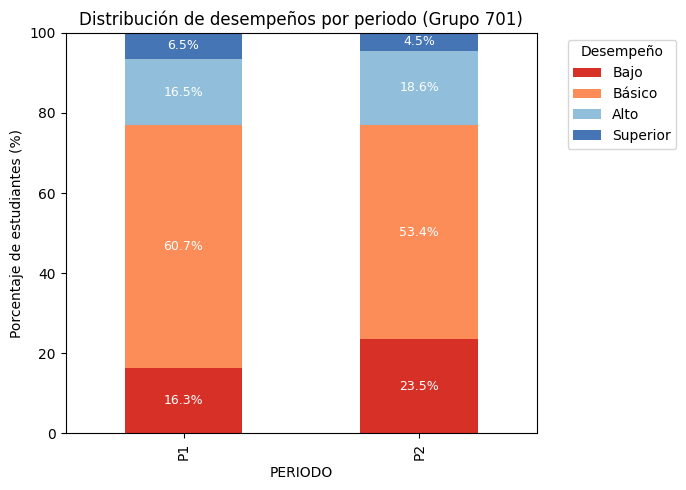

In [59]:
import matplotlib.pyplot as plt

# Paso 1: Gráfico de distribución de desempeños P1 vs P2 (barras apiladas)

# Recalcular distribución porcentual de desempeño por periodo
dist_pct = pd.crosstab(df["PERIODO"], df["DESEMPEÑO"], normalize="index")*100

# Ordenar columnas de desempeño según escala
orden_desempeno = ["Bajo", "Básico", "Alto", "Superior"]
dist_pct = dist_pct[orden_desempeno]

# Gráfico
fig, ax = plt.subplots(figsize=(7,5))
bars = dist_pct.plot(
    kind="bar", stacked=True, ax=ax,
    color=["#d73027", "#fc8d59", "#91bfdb", "#4575b4"]
)

ax.set_ylabel("Porcentaje de estudiantes (%)")
ax.set_title("Distribución de desempeños por periodo (Grupo 701)")
ax.legend(title="Desempeño", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylim(0,100)

# Añadir etiquetas de porcentaje en cada sección de barra
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", color="white", fontsize=9)

plt.tight_layout()
plt.show()


## Gráfico de promedio de notas por materia (P1 vs P2, barras agrupadas)

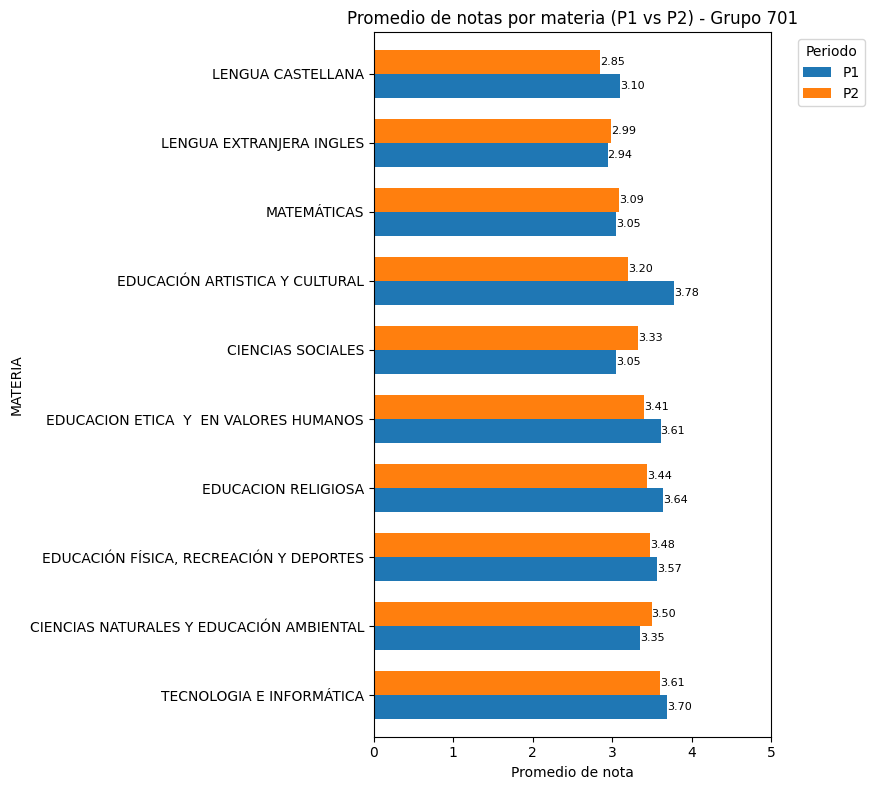

In [66]:
# Paso 2: Gráfico de promedio de notas por materia (P1 vs P2, barras agrupadas)

# Calcular promedios por materia y periodo
promedio_materia = df.groupby(["MATERIA", "PERIODO"])["NOTA"].mean().reset_index()

# Pivot para graficar P1 vs P2
pivot_promedio = promedio_materia.pivot(index="MATERIA", columns="PERIODO", values="NOTA")

# Ordenar materias por promedio de P2 (si existe)
if "P2" in pivot_promedio.columns:
    pivot_promedio = pivot_promedio.sort_values("P2", ascending=False)

# Reordenar columnas para que siempre aparezca primero P1 y luego P2
cols = [c for c in ["P1", "P2"] if c in pivot_promedio.columns]
pivot_promedio_ordered = pivot_promedio[cols]

# Gráfico horizontal con orden P1, luego P2
fig, ax = plt.subplots(figsize=(9,8))
pivot_promedio_ordered.plot(kind="barh", ax=ax, width=0.7)

ax.set_xlabel("Promedio de nota")
ax.set_title("Promedio de notas por materia (P1 vs P2) - Grupo 701")
ax.legend(title="Periodo", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xlim(0,5)

# Etiquetas
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=8)

plt.tight_layout()
plt.show()


## Evolución por estudiante (P1 vs P2, dispersión comparativa)

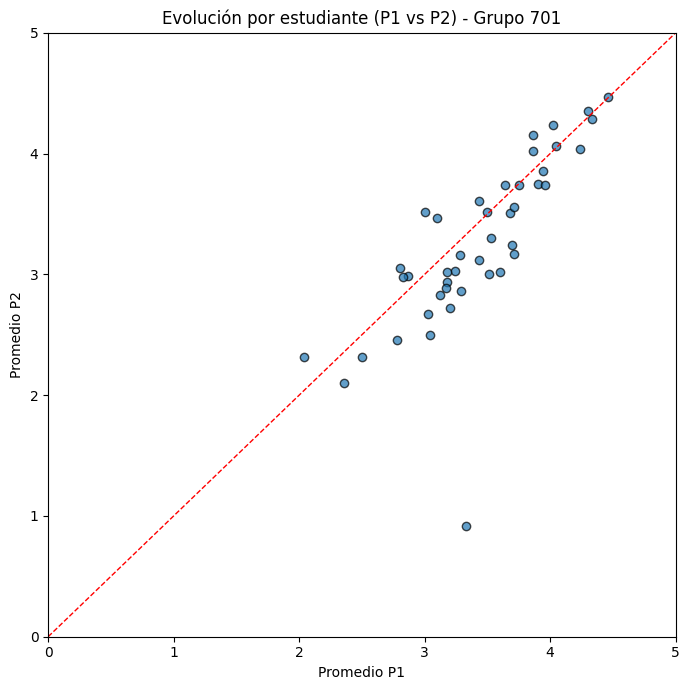

In [67]:
# Paso 3: Evolución por estudiante (P1 vs P2, dispersión comparativa)

# Usar la tabla pivot_evolucion creada antes (con P1 y P2)
scatter_data = pivot_evolucion.dropna(subset=["P1", "P2"])

fig, ax = plt.subplots(figsize=(7,7))

# Dispersión P1 vs P2
ax.scatter(scatter_data["P1"], scatter_data["P2"], alpha=0.7, edgecolors="k")

# Línea de referencia (y = x) para ver si mejoró/empeoró
ax.plot([0,5], [0,5], "r--", linewidth=1)

ax.set_xlabel("Promedio P1")
ax.set_ylabel("Promedio P2")
ax.set_title("Evolución por estudiante (P1 vs P2) - Grupo 701")
ax.set_xlim(0,5)
ax.set_ylim(0,5)

plt.tight_layout()
plt.show()


## Diferencia de evolución por estudiante (P2 - P1 en barras horizontales)

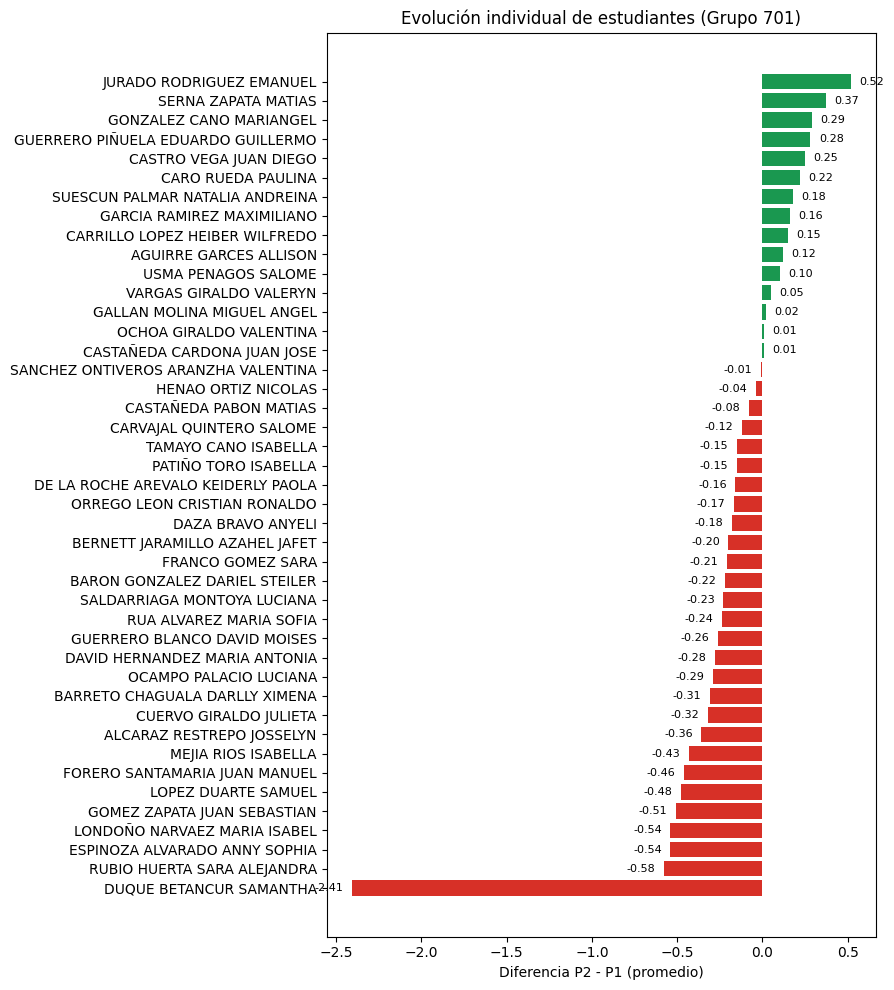

In [68]:
# Paso 4: Diferencia de evolución por estudiante (P2 - P1 en barras horizontales)

# Filtrar solo quienes tienen ambos periodos
diff_data = pivot_evolucion.dropna(subset=["P1", "P2"]).copy()

# Ordenar por diferencia
diff_data = diff_data.sort_values("Diferencia_P2_P1")

fig, ax = plt.subplots(figsize=(9,10))
bars = ax.barh(diff_data["Nombre_estudiante"], diff_data["Diferencia_P2_P1"], color=["#d73027" if x<0 else "#1a9850" for x in diff_data["Diferencia_P2_P1"]])

ax.set_xlabel("Diferencia P2 - P1 (promedio)")
ax.set_title("Evolución individual de estudiantes (Grupo 701)")

# Etiquetas en barras
for bar in bars:
    width = bar.get_width()
    ax.text(width + (0.05 if width>=0 else -0.05),
            bar.get_y() + bar.get_height()/2,
            f"{width:.2f}", va="center",
            ha="left" if width>=0 else "right",
            fontsize=8)

plt.tight_layout()
plt.show()


## Distribución de alertas académicas en P2 (pie chart / donut)

La alerta se definió a partir del promedio del estudiante en P2 (es decir, cómo cerró el segundo periodo):

Alerta: Bajo → promedio < 3.0
🔴 Estudiante en riesgo de pérdida.
Necesita plan de recuperación urgente.

Atención: Básico → promedio entre 3.0 y 3.9
🟠 Estudiante en desempeño bajo-intermedio.
No pierde todavía, pero está en la franja de vulnerabilidad.
Con una caída más, podría pasar a Bajo.

Sin alerta → promedio ≥ 4.0
🔵 Estudiante en nivel Alto o Superior.
Se considera estable y sin riesgo inmediato.

🤔 ¿Por qué hacerlo así?

Es un semáforo rápido para ubicar a los estudiantes según riesgo.

Complementa el nivel de desempeño, pero enfocado en alertar la acción:

🔴 Requiere intervención urgente.

🟠 Requiere seguimiento preventivo.

🔵 Se puede trabajar en profundización y motivación.

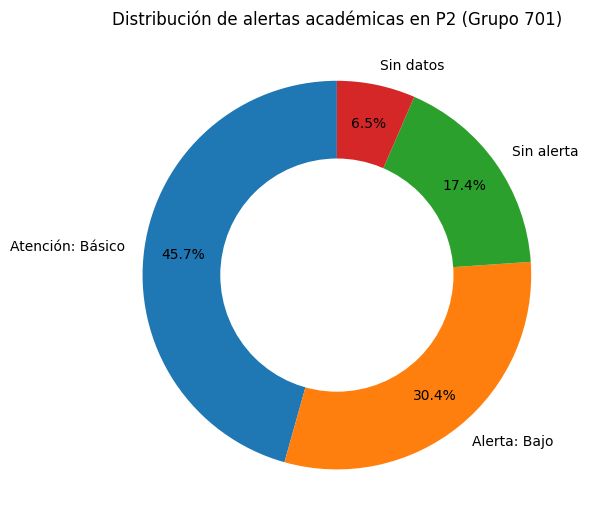

In [69]:
# Paso 5: Distribución de alertas académicas en P2 (pie chart / donut)

# Tomar solo las etiquetas de alerta de P2
alertas = pivot_evolucion["Alerta_P2"].value_counts()

fig, ax = plt.subplots(figsize=(6,6))

# Pie chart tipo donut
wedges, texts, autotexts = ax.pie(
    alertas,
    labels=alertas.index,
    autopct="%.1f%%",
    startangle=90,
    pctdistance=0.8
)

# Donut: círculo blanco en el centro
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title("Distribución de alertas académicas en P2 (Grupo 701)")

plt.tight_layout()
plt.show()


# HEATMAP

C:\Users\User\AppData\Local\Temp\ipykernel_10648\3770665513.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = alertas_materia.replace(map_alerta)


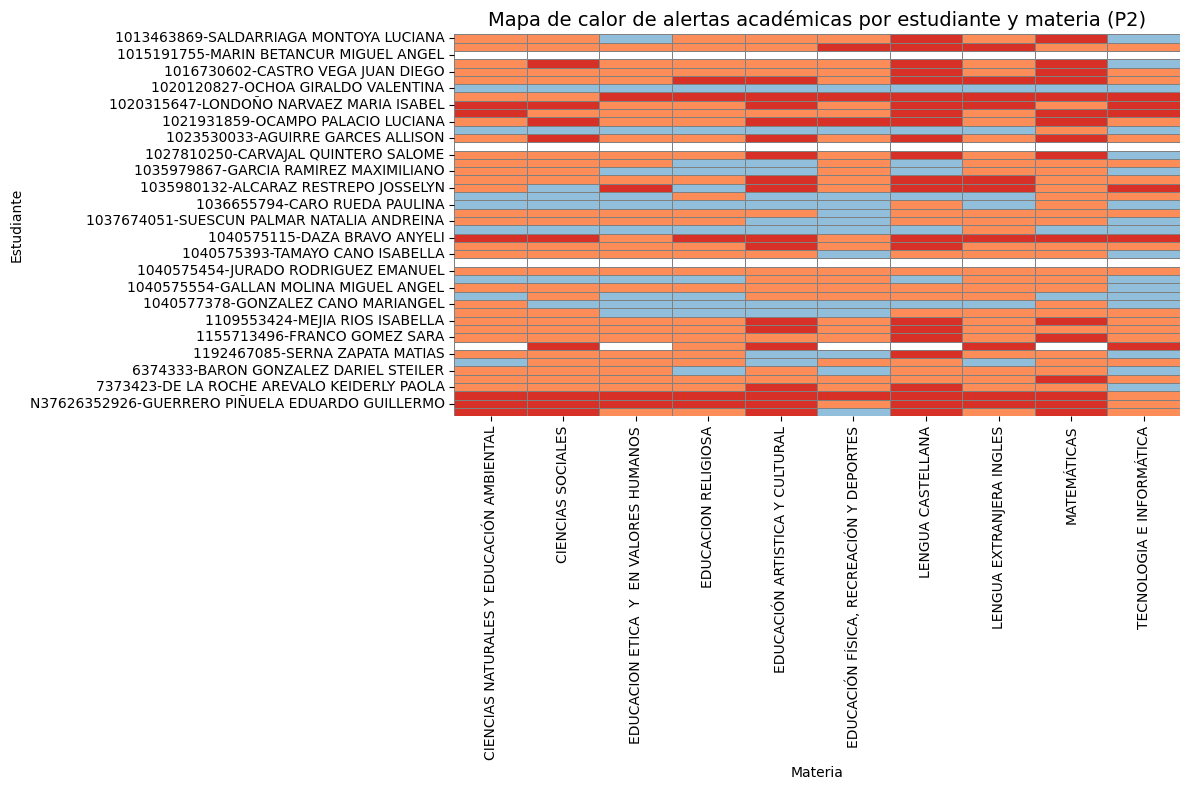

In [74]:
# Paso 6: Heatmap de alertas por materia (P2)

# Convertir alertas a códigos numéricos para graficar con colores
map_alerta = {
    "Alerta: Bajo": 0,      # rojo
    "Atención: Básico": 1,  # naranja
    "Sin alerta": 2,        # azul
    "Sin datos": np.nan     # blanco
}
heatmap_data = alertas_materia.replace(map_alerta)

# Configuración del gráfico
plt.figure(figsize=(12,8))
sns.heatmap(
    heatmap_data,
    cmap=sns.color_palette(["#d73027", "#fc8d59", "#91bfdb"]), # rojo-naranja-azul
    cbar=False,
    linewidths=0.5,
    linecolor="gray"
)

plt.title("Mapa de calor de alertas académicas por estudiante y materia (P2)", fontsize=14)
plt.xlabel("Materia")
plt.ylabel("Estudiante")

plt.tight_layout()
plt.show()


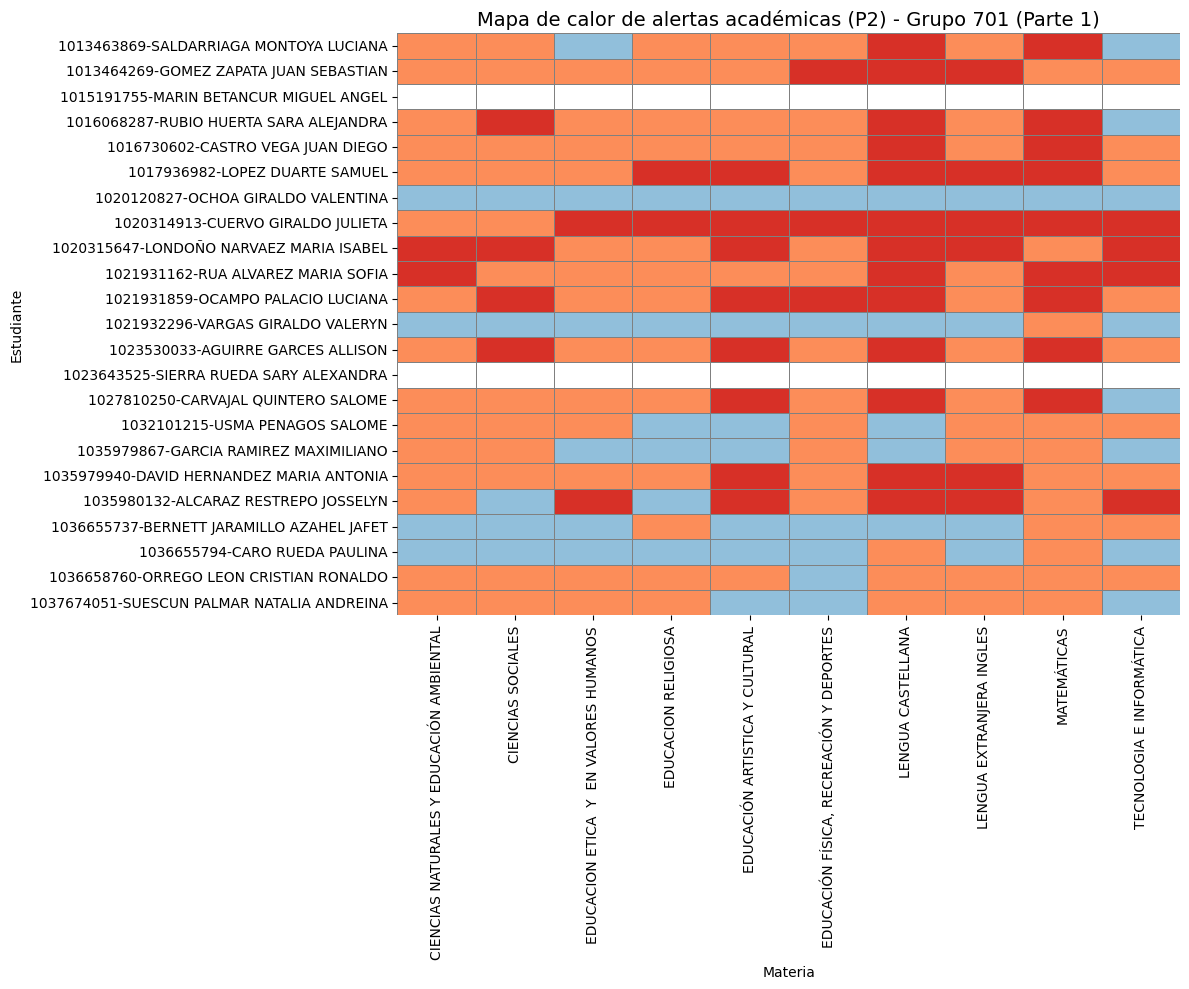

In [77]:
# Dividir el heatmap en dos mitades de estudiantes para mejor visualización

# Número de estudiantes
n_estudiantes = heatmap_data.shape[0]
mitad = n_estudiantes // 2

# Primera mitad
heatmap_1 = heatmap_data.iloc[:mitad]
# Segunda mitad
heatmap_2 = heatmap_data.iloc[mitad:]

# Heatmap 1
plt.figure(figsize=(12,10))
sns.heatmap(
    heatmap_1,
    cmap=sns.color_palette(["#d73027", "#fc8d59", "#91bfdb"]), # rojo-naranja-azul
    cbar=False,
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Mapa de calor de alertas académicas (P2) - Grupo 701 (Parte 1)", fontsize=14)
plt.xlabel("Materia")
plt.ylabel("Estudiante")
plt.tight_layout()
plt.show()


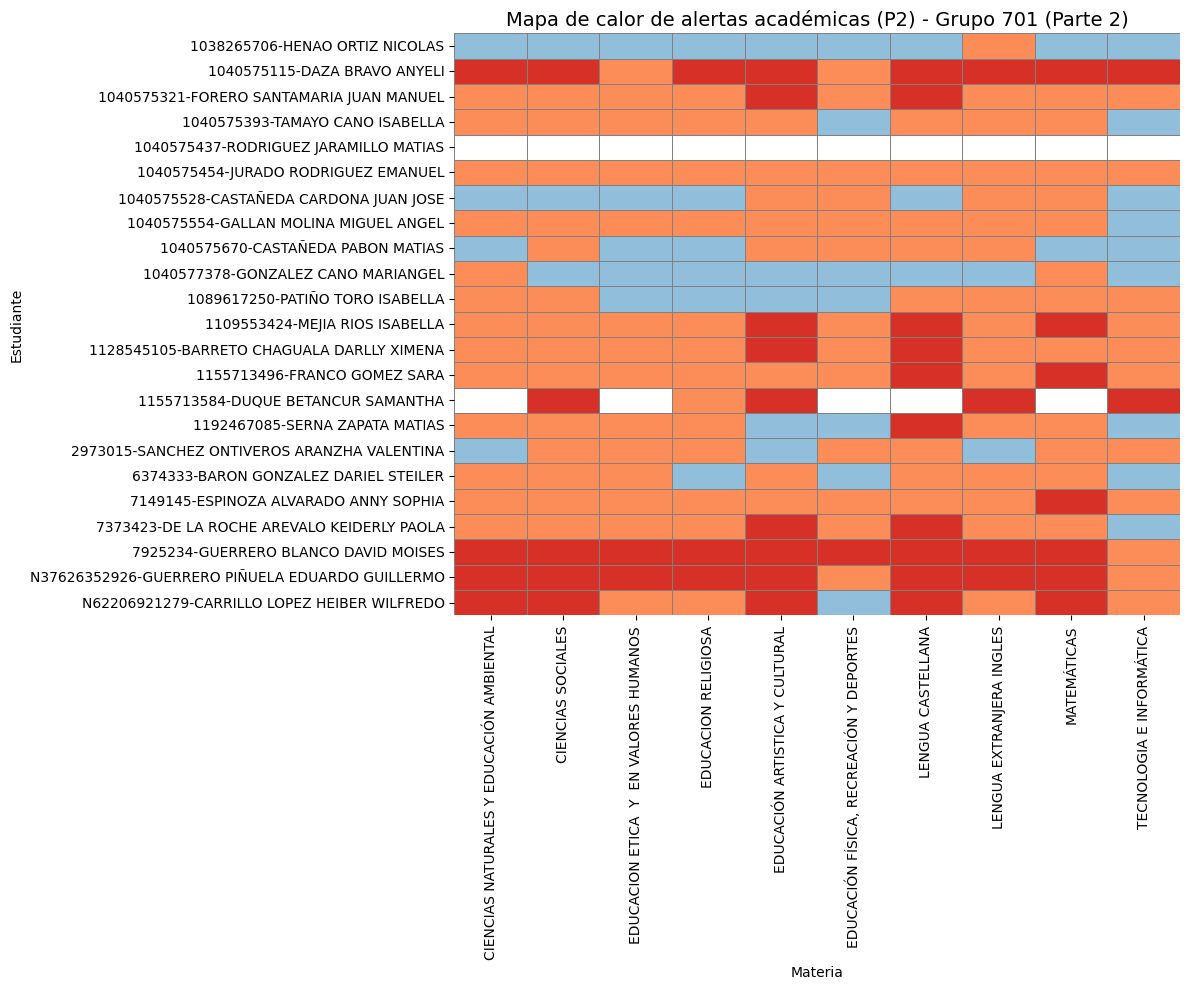

In [79]:
# Heatmap 2
plt.figure(figsize=(12,10))
sns.heatmap(
    heatmap_2,
    cmap=sns.color_palette(["#d73027", "#fc8d59", "#91bfdb"]), # rojo-naranja-azul
    cbar=False,
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Mapa de calor de alertas académicas (P2) - Grupo 701 (Parte 2)", fontsize=14)
plt.xlabel("Materia")
plt.ylabel("Estudiante")
plt.tight_layout()
plt.show()